In [1]:
# A utiliser pour faire du Transfer Learning

from google.colab import drive
drive.mount("/content/drive")

path_data = '/content/drive/MyDrive/Colab/'

Mounted at /content/drive


In [ ]:
!pip install tensorflow_hub
!pip install tensorflow_text
!pip install -U gensim
!pip install pyLDAvis

# Projet NLP: Suggestions de Tags


Après avoir procéder à la préparation du jeu de données dans le notebook précédent, nous allons maintenant modéliser le système de suggestion des tags. Dans ce notebook, on appliquera des modèles d'apprentissages supervisés suivant les deux approches Machine et Deep Learning.


Dans un premier temps, on applique la classification non-supervisée type *Topic Modelling* (approche Machine Learnnig) à l'aide l'algorithme LDA *(Latent Dirichlet Allocation)* de la bibliothèque Python `gensim` sur l'ensemble du jeu d'entraînement. Cette technique de classification permet, en NLP, d'expliquer un document comme une distribution de probabilités de *topics*, ces derniers donnés par une distribution de probabilités de mots-clés (*keywords*). Chaque topic est donc déterminé par les keywords qu'il contient. Le nombre de topics doit être fixé à l'avance, l'apprentissage LDA permet alors d'ajuster la distribution des topics parmi les documents et la distribution des keywords parmi les topics. Une fois la classification optimale des documents obtenue, on utilise une fonction score customisée pour construire une méthode de suggestion de tags.

Dans un second temps, on s'intéressera aux architectures de réseaux de neuronnes (Deep Learning) également très utilisé pour le NLP. On présente ici trois modèles d'apprentissage supervisé: Dans le premier modèle, on va créer un embedding Word2Vec pour tout les mots du corpus d'entrainement à l'aide de `gensim`. Le modèle d'apprentissage sera construit à l'aide de la bibliothèque `Keras`. Pour construire les deux derniers modèles de suggestions, on utilisera deux modèles pré-entraînés comme point de départ (*Transfer Learning*): `BERT` et `Universal Sentence Encoder`. Ces derniers sont optimisés pour permettre d'effectuer des tâches NLP classiques telle que la classification ou l'analyse sémantique.

Il est à noter que les métriques d'évaluations pour les problèmes de classification multi-label diffèrent légèrement des problèmes de classifications classiques. En effet, les prédictions peuvent être partiellement correcte ou partiellement incorrecte, ce qui ne peut pas se produire pour la classification binaire ou multi-classe. Pour mesurer la qualité des suggestions (sur le test set), on interpretera les résultats pour chaque modèle via la *précision* et le *rappel*. En particulier, on va suivre les meilleurs prédictions via le *f1-score* qui représente la moyenne harmonique de la précision et du rappel.

  
# <font color="#00afe6">Sommaire</font>
1. [Préparation du jeu de données.](#section_1)                       
2. [Train / val / test split.](#section_2)     
3. [Suggestion supervisée avec LDA.](#section_3)     
    3.1 [Recherche du nombre de topics optimal.](#section_3_1)            
    3.2 [Fonction "score" pour le système de suggestion.](#section_3_2)            
    3.3 [Inférence sur le test set.](#section_3_3)           
    3.4 [Évaluations des suggestions.](section_3_4)                
4. [Suggestion avec modèle Word2Vec.](#section_4)             
5. [Modélisation via Transfer Learning.](#section_5)                           
    5.1 [Suggestion avec le modèle BERT.](#section_5_1)                   
    5.2 [Suggestion avec le modèle USE.](#section_5_2)                     

In [3]:
# Importation des librairies python

import sys, time

import re, numpy as np, pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt


from random import randint
from ast import literal_eval
from tqdm import tqdm
tqdm.pandas()

import gensim

import tensorflow as tf
import tensorflow.keras as keras 

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [6]:
# # A utiliser en local
# path_data = ''

# Chargement
df = pd.read_csv(path_data + 'df_preclean_lemma.csv', index_col=0)

print("Le dataframe contient {} colonnes et {} lignes."\
      .format(df.shape[1],df.shape[0]))

Le dataframe contient 3 colonnes et 37960 lignes.


# <font color="red" id=section_1> 1. Préparation du jeu de données. </font>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37960 entries, 689677 to 665299
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Best_Tags  37960 non-null  object
 1   Body_pc    37960 non-null  object
 2   Body_lm    37960 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [8]:
df.sample(1)

,Best_Tags,Body_pc,Body_lm
Id,,,
3933668,"['php', 'arrays']",convert array into csv. how to convert an array into a csv file? this is my array,convert array csv convert array csv array


Le dataframe contient deux colonnes de textes (`Body_lm` et `Body_pc`) qui seront utilisées selon le modèle employé. La colonne `Body_lm` contenant du texte *tokenized* et *lemmatized* sera utilisée pour les modèles LDA et Word2Vec. La colonne `Body_pc` qui contient les textes pré-nettoyés (conserve du "context" par rapport à la variable précédente) sera utilisée pour le transfert learning.

La colonne `Best_Tags` est la colonne cible.

In [9]:
df['Best_Tags'] = df['Best_Tags'].progress_apply(lambda x: literal_eval(x))

100%|██████████| 37960/37960 [00:00<00:00, 87792.72it/s]


In [10]:
def split_and_count_tags(df, column, separator):
    list_words = []
    for word in df[column]: #.str.split(separator):
        list_words.extend(word)
    df_list_words = pd.DataFrame(list_words, columns=["Tag"])
    df_list_words = df_list_words.groupby("Tag")\
        .agg(tag_count=pd.NamedAgg(column="Tag", aggfunc="count"))
    df_list_words.sort_values("tag_count", ascending=False, inplace=True)
    return df_list_words

tags_list_df = split_and_count_tags(df=df, column='Best_Tags', separator=',')
tags_list_df.head()

,tag_count
Tag,
python,4528
java,4293
c#,4088
javascript,4070
android,2776


In [11]:
nbr_tags = tags_list_df.shape[0]

print("Le jeu de données compte {} tags.".format(nbr_tags))
tags_list = tags_list_df.reset_index()['Tag'].values.tolist()

Le jeu de données compte 35 tags.


Dans le but d'avoir une modélisation rapide et légère, la taille maximale du corps du texte (nombre de *tokens*) sera fixée à 128. Toutes les séquences ayant une longueur supérieure à ce seuil seront tronqués. 

In [12]:
def troncate_SeqLen(df, columns, maxSeq_len):
    for col in columns:
        for idx, data in tqdm(df[col].apply(lambda x: x.split(" ")).items(), total=len(df)):    
            if (len(data) > maxSeq_len):
                df[col].loc[idx] = " ".join(data[:maxSeq_len]) #.loc[i]
    return df 

def token_distribution(df,col):
    tk = [len(body) for body in df[col].apply(lambda x: x.split(" "))]
    print(f"\n Le corps de texte le plus long contient {max(tk)} tokens. \n")

    plt.figure(figsize=(15,6))
    plt.hist(tk, bins=100)
    plt.title(f"Distribution du nombre de token dans la colonne {col}", fontsize=18)
    plt.xlabel('Nombre de tokens', fontsize=18)
    plt.xticks(fontsize=15)
    plt.ylabel('Nombre de documents', fontsize=18 )
    plt.yticks(fontsize=15)
    plt.show()

In [13]:
maxSeq_len = 128

df_troncated = troncate_SeqLen(df=df, columns=['Body_lm', 'Body_pc'], maxSeq_len=maxSeq_len)

tags_troncated_list_df = split_and_count_tags(df=df_troncated, column='Best_Tags', separator=',')
nbr_tags               = tags_troncated_list_df.shape[0]

print("Le dataframe compte à présent {} lignes et {} tags uniques".format(df_troncated.shape[0], nbr_tags))

100%|██████████| 37960/37960 [00:03<00:00, 11729.06it/s]


Le dataframe compte à présent 37960 lignes et 35 tags uniques



 Le corps de texte le plus long contient 128 tokens. 



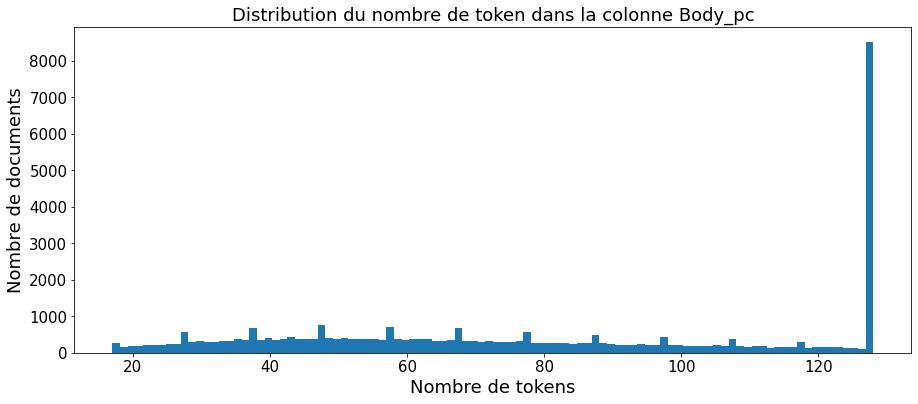

In [14]:
token_distribution(df_troncated, 'Body_pc')


 Le corps de texte le plus long contient 128 tokens. 



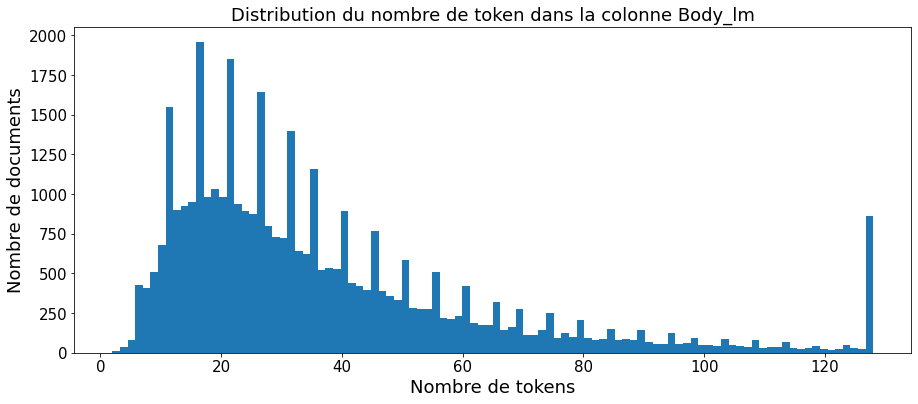

In [15]:
token_distribution(df_troncated, 'Body_lm')

# <font color="red" id=section_2> 2. Train / test split. </font>

In [16]:
def split_train_test_data(dataset, train_ratio = 0.9):
    # shuffle dataset
    dataset = dataset.sample(frac=1)

    # train set
    np.random.seed(seed=0)
    train_msk = np.random.rand(len(dataset)) < train_ratio
    train_df = dataset[train_msk]
    print('train_df shape = ', train_df.shape)

    # eval_test set
    test_df  = dataset[~train_msk]
    print('test_df shape = ', test_df.shape)
    
    return train_df, test_df

# Target Labels Binarizer
def binarize_target(train_df, test_df, mlb, column):

    train_label = train_df[column].values.tolist()
    test_label  = test_df[column].values.tolist()

    mlb.fit(train_label)

    train_label_bin = mlb.transform(train_label)
    test_label_bin = mlb.transform(test_label)

    print("Shape of y train: {}".format(train_label_bin.shape))
    print("Shape of y test: {}".format(test_label_bin.shape))
    
    return train_label_bin, test_label_bin, mlb

Tout au long de ce notebook, nous allons utiliser les mêmes jeux d'entraînements et de tests pour entraîner et comparer les différentes modélisations du système de suggestions.

In [17]:
train_df, test_df = split_train_test_data(df_troncated, train_ratio = 0.96)

##
print()
mlb = MultiLabelBinarizer()
train_label_bin, test_label_bin, mlb = binarize_target(train_df, test_df, mlb, 'Best_Tags')

##
train_label_tags  = mlb.inverse_transform(train_label_bin)
train_label_count = [len(taggs) for taggs in train_label_tags]

test_label_tags   = mlb.inverse_transform(test_label_bin)
test_label_count  = [len(taggs) for taggs in test_label_tags]

train_df shape =  (36464, 3)
test_df shape =  (1496, 3)

Shape of y train: (36464, 35)
Shape of y test: (1496, 35)


In [18]:
def plot_tag_list_count(label_tags, label_count):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

    pd.DataFrame(label_tags).stack().value_counts().plot(
        kind="bar", 
        ax=axes[0], 
        title='Distribution des tags')
    print('unique tags := ', pd.DataFrame(label_tags).stack().nunique())
  
    pd.DataFrame({'Nombre de tags': label_count}).value_counts().plot(
        kind="bar", 
        ax=axes[1], 
        rot=0, 
        title='Total du nombre de tags par questions')
    plt.show()

unique tags :=  35


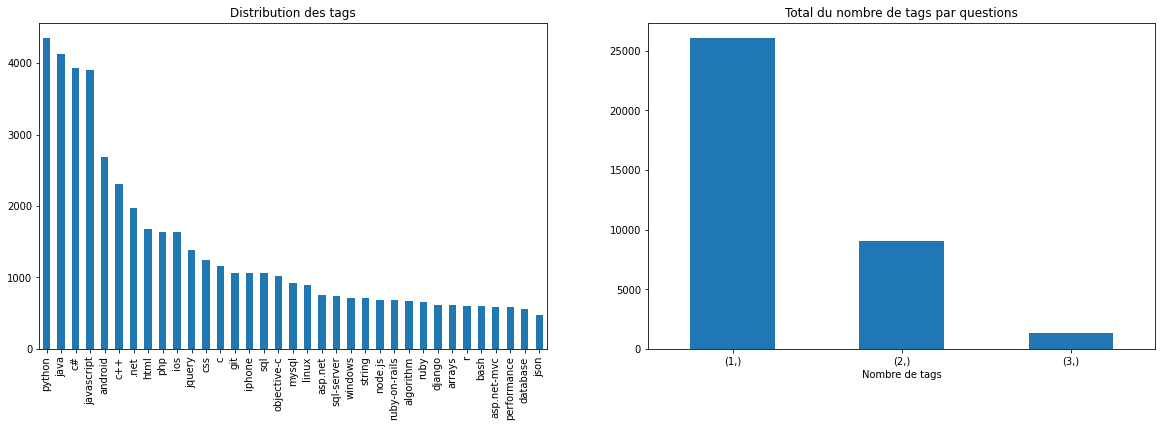

In [19]:
plot_tag_list_count(train_label_tags, train_label_count)

unique tags :=  35


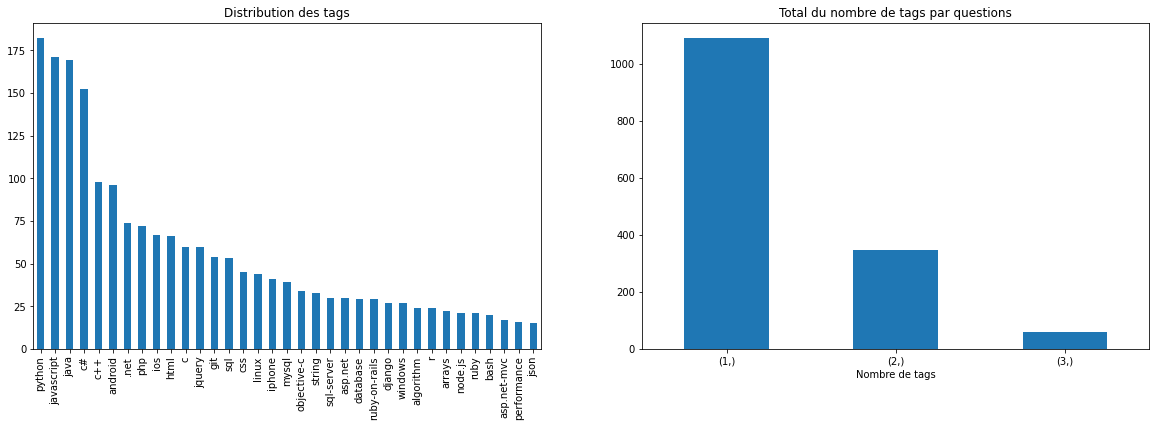

In [20]:
plot_tag_list_count(test_label_tags, test_label_count)

In [28]:
# # On sauvegarde ces dataframes pour pouvoir comparer les modeles avec les memes train & test sets
# train_df.to_csv(path_data + 'train_df_tronc.csv')
# test_df.to_csv(path_data + 'test_df_tronc.csv')


 Le corps de texte le plus long contient 128 tokens. 



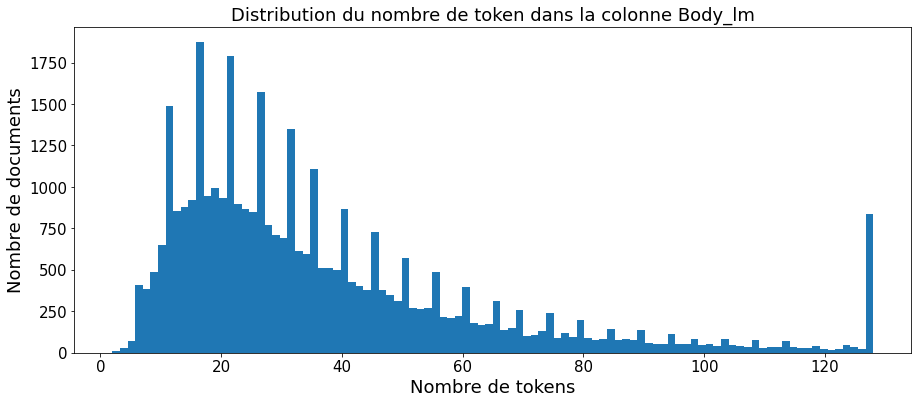

In [22]:
token_distribution(train_df, 'Body_lm')


 Le corps de texte le plus long contient 128 tokens. 



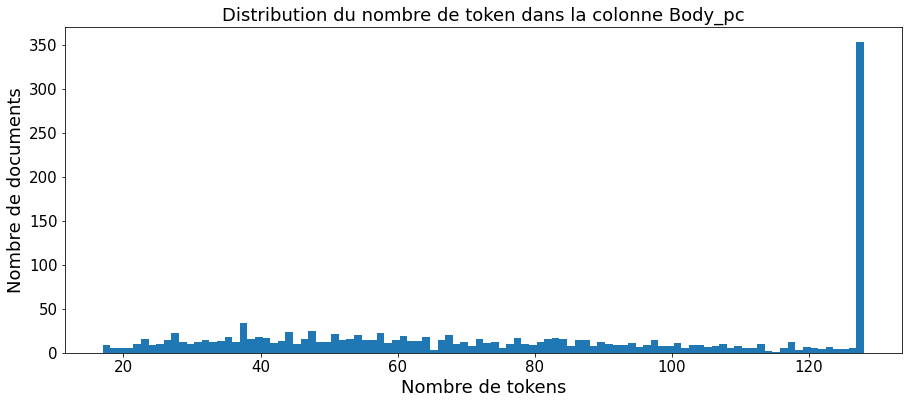

In [23]:
token_distribution(test_df, 'Body_pc')

In [24]:
def load_train_test_corpus(train_name, test_name, body, mlb, apply=True, path_data=path_data):

    print('Load '+ train_name)
    train_corpus_df = pd.read_csv(path_data + train_name, index_col=0)
    print('Load '+ test_name)
    test_corpus_df = pd.read_csv(path_data + test_name, index_col=0)
    print()
    
    print('Features:')
    if apply:
      train_feats = train_corpus_df[body].apply(lambda x: x.split(" "))
      test_feats = test_corpus_df[body].apply(lambda x: x.split(" ")) 
    else:
      train_feats = train_corpus_df[body]
      test_feats = test_corpus_df[body]
    print("Shape of x train: {}".format(train_feats.shape))
    print("Shape of x test: {}".format(test_feats.shape))
    print()
    
    print('Target Binarization:')
    train_corpus_df['Best_Tags'] = train_corpus_df['Best_Tags'].progress_apply(lambda x: literal_eval(x))
    test_corpus_df['Best_Tags']  = test_corpus_df['Best_Tags'].progress_apply(lambda x: literal_eval(x))
    train_label_bin, test_label_bin, mlb = binarize_target(train_corpus_df, test_corpus_df, mlb, 'Best_Tags')
    
    return train_feats, test_feats, train_label_bin, test_label_bin, mlb

In [25]:
# On utilisera la fonction ci-dessous pour afficher l'historique de l'entraînement des modèles DL

def plot_model_history(model):
  
    acc      = model.history.history[list(model.history.history.keys())[1]]
    val_acc  = model.history.history[list(model.history.history.keys())[3]]
    loss     = model.history.history[list(model.history.history.keys())[0]]
    val_loss = model.history.history[list(model.history.history.keys())[2]]
    epochs   = model.history.epoch

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()  

# <font color="red" id=section_3> 3. Suggestion supervisée avec LDA. </font>

In [ ]:
# Chargement des jeux de données train & test
Body = 'Body_lm'

mlb = MultiLabelBinarizer()

train_feats, test_feats, train_label_bin, test_label_bin, mlb = load_train_test_corpus(
    'train_df_tronc.csv',
    'test_df_tronc.csv',
    Body,
    mlb
)

Load train_df_tronc.csv
Load test_df_tronc.csv

Features:
Shape of x train: (36465,)
Shape of x test: (1496,)

Target Binarization:


100%|██████████| 1496/1496 [00:00<00:00, 111278.82it/s]


Shape of y train: (36465, 35)
Shape of y test: (1496, 35)


On crée le **Corpus** et le **Dictionnaire** qui sont les deux principales *inputs* pour la LDA permettant la vectorisation du texte. 

In [ ]:
import gensim.corpora as corpora

data_ready = train_feats.copy()

# Create Dictionary
dictionnaire = corpora.Dictionary(data_ready)
dictionnaire.filter_extremes(no_below=2, keep_n=None)

# Create Corpus: Term Document Frequency
corpus = [dictionnaire.doc2bow(text) for text in data_ready]

In [ ]:
# Taille du dictionnaire :
len(dictionnaire)

14029

## <font color="red" id=section_3_1> 3.1 Recherche du nombre de topics optimal. </font>

Pour trouver le nombre optimal de topics, il faut procéder comme avec la méthode du coude. On utilise la *Cohérence* comme métrique.

In [ ]:
from gensim.models import CoherenceModel

# # Hyperparameters that affect sparsity of the topics
# model_alpha = 'symmetric'

# Iter LDA for best number of topics
coherence_test = []
for k in np.arange(1,50,5):
    print("Fitting LDA for K = {} topics".format(k))
    start_time = time.time()

    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=dictionnaire,
                                                        num_topics=k,
                                                        random_state=0,
#                                                         alpha=model_alpha,
                                                        passes=10,
                                                        iterations=150,
                                                        per_word_topics=False,
                                                        workers=8)
    # métrique
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=data_ready,
                                         dictionary=dictionnaire,
                                         coherence='c_v')
    
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1 topics
Fitting LDA for K = 6 topics
Fitting LDA for K = 11 topics
Fitting LDA for K = 16 topics
Fitting LDA for K = 21 topics
Fitting LDA for K = 26 topics
Fitting LDA for K = 31 topics
Fitting LDA for K = 36 topics
Fitting LDA for K = 41 topics
Fitting LDA for K = 46 topics


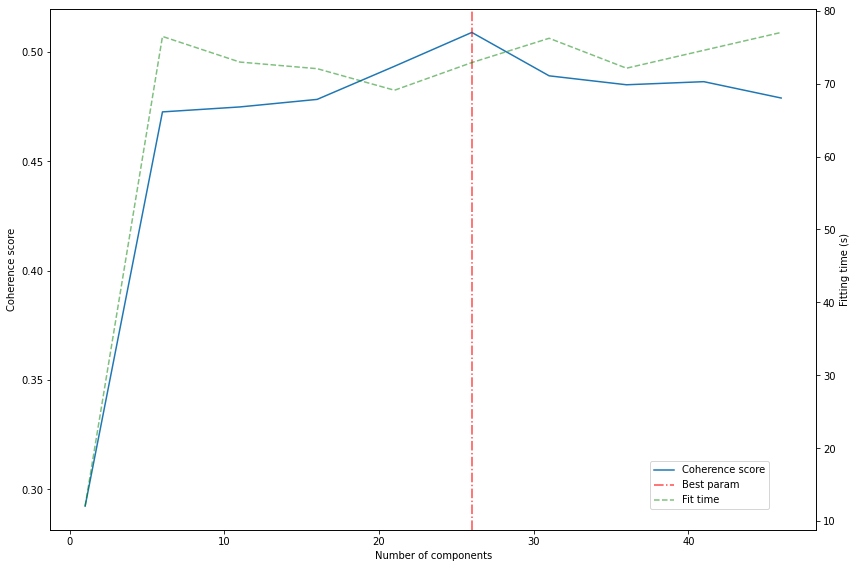

In [ ]:
# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])

# Select best number of topics
best_nb_topics = coherence_test\
                    .loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_nb_topics, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

legend = fig.legend(loc='lower right', bbox_to_anchor=(.9, .1))

fig.tight_layout()
plt.show()
# fig.savefig('best_nb_topic.png')

In [ ]:
print(f"Le nombre optimal de topics obtenus est de {best_nb_topics}.")

Le nombre optimal de topics obtenus est de 26.


On va maintenant ré-entrainer le modèle avec ce nombre de topic et obtenir toute les probabilités ayant été calculées. Il est à noter que ce "nombre optimal" peut varier entre 10 et 30, en fonction des hyperparamètres du modèle `gensim` (comme du *random_state* par exemple), cependant l'ordre de grandeur de la Cohérence reste entre 0.45 de 0.5.

In [ ]:
num_topic = best_nb_topics

lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                    id2word=dictionnaire,
                                                    num_topics=num_topic,
                                                    random_state=100,
                                                    passes=10,
                                                    iterations=150,
#                                                     alpha=model_alpha,
                                                    workers=8)

In [ ]:
#Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=data_ready, 
                                     dictionary=dictionnaire, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5314135418245005


Maintenant que le modèle LDA est construit avec le nombre optimal de topics, on peut "visualiser" (projection sur un plan bidimensionnel) les topics ainsi que les keywords associés à l'aide du package de visualition `pyLDAvis`.

In [ ]:
import pyLDAvis
# import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from IPython.core.display import display, HTML
pyLDAvis.enable_notebook()

display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

gensimvis.prepare(lda_model, corpus, dictionnaire)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.152127  0.110123       1        1  5.749098
8      0.112171 -0.012324       2        1  5.514472
1     -0.116594  0.172091       3        1  5.307692
24     0.159421 -0.000723       4        1  5.129904
6      0.051305 -0.095720       5        1  4.988779
3      0.096106  0.022611       6        1  4.988174
7      0.013565 -0.129152       7        1  4.649041
15    -0.155205 -0.077771       8        1  4.431606
20    -0.038743 -0.108334       9        1  4.296837
19     0.087046  0.064903      10        1  4.292584
12     0.055506  0.127239      11        1  4.152915
25    -0.010013 -0.098599      12        1  4.085089
16    -0.096789  0.059234      13        1  3.876680
13     0.067711  0.047449      14        1  3.855890
17    -0.116718  0.124179      15        1  3.725832
21    -0.118368 -0.093442      16        1  3.403161
23    -0.087194 -0.061642      17        1  3.389956
11    -0.150460  0.116450      18        1  3.073882
9      0.042157 -0.000663      19        1  2.996190
4     -0.002046 -0.052227      20        1  2.920570
10     0.017595 -0.068552      21        1  2.839079
5      0.042992 -0.035982      22        1  2.773766
2     -0.054270 -0.060286      23        1  2.628100
22    -0.089470  0.054241      24        1  2.588223
14     0.083737  0.063366      25        1  2.219609
18     0.054432 -0.066467      26        1  2.122871, topic_info=         Term         Freq        Total Category  logprob  loglift
168    string  5384.000000  5384.000000  Default  30.0000  30.0000
61      class  7078.000000  7078.000000  Default  29.0000  29.0000
93     object  6046.000000  6046.000000  Default  28.0000  28.0000
288     image  4104.000000  4104.000000  Default  27.0000  27.0000
105     table  4204.000000  4204.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1023  program   122.033993  2501.806299  Topic26  -5.4501   0.8319
381      mean   118.680200  2188.567481  Topic26  -5.4780   0.9378
787      loop   111.431404  1512.066555  Topic26  -5.5410   1.2446
742      fail   109.620990  1450.419100  Topic26  -5.5574   1.2698
31      point   112.438542  2419.638810  Topic26  -5.5320   0.7834

[1994 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2245      5  0.031614     +
2245      6  0.050583     +
2245     10  0.360403     +
2245     19  0.018969     +
2245     21  0.499506     +
...     ...       ...   ...
1061     12  0.005739  zoom
1061     14  0.017218  zoom
1061     16  0.005739  zoom
1061     24  0.011478  zoom
9213     17  0.955655   zxe

[12079 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 2, 25, 7, 4, 8, 16, 21, 20, 13, 26, 17, 14, 18, 22, 24, 12, 10, 5, 11, 6, 3, 23, 15, 19])

Sur le diagrame ci-dessous est illustré une projection de la classification éffectuée par la LDA. Bien qu'il y ait des chevauchements entre quelques topics, on distingue clairement les topics les uns des autres. Exemples de groupes identifié via LDA:
 1. `git, commit, change, branch, repositery` 
 2. `database, sql, mysql, server, table`
 3. `command, linux, bash`
 4. `javascript, event `
 5. `python, install`
 6. `java, application`
 7. `c++, function,`

Ci-dessous, on montre pour chaque séquences les topics dominants et leurs contributions respectives.

In [ ]:
doc_all_topics = lda_model.get_document_topics(corpus)

print('(Topic Dominant, Document) Contribution')
print(gensim.matutils.corpus2csc(doc_all_topics))

(Topic Dominant, Document) Contribution
  (0, 0)	0.16074234247207642
  (6, 0)	0.29109060764312744
  (9, 0)	0.48917120695114136
  (2, 1)	0.28215059638023376
  (8, 1)	0.2214713841676712
  (25, 1)	0.4786730706691742
  (20, 2)	0.6572076082229614
  (23, 2)	0.28508996963500977
  (1, 3)	0.5374205708503723
  (3, 3)	0.07538279891014099
  (14, 3)	0.07515707612037659
  (17, 3)	0.2794691026210785
  (0, 4)	0.2041626125574112
  (4, 4)	0.09397684782743454
  (12, 4)	0.39659106731414795
  (13, 4)	0.04034557566046715
  (23, 4)	0.17807164788246155
  (25, 4)	0.0758492648601532
  (3, 5)	0.08087185025215149
  (11, 5)	0.6360141634941101
  (17, 5)	0.25457242131233215
  (1, 6)	0.5902436375617981
  (12, 6)	0.11485117673873901
  (17, 6)	0.1533251702785492
  (24, 6)	0.12356741726398468
  :	:
  (9, 36457)	0.38374167680740356
  (19, 36458)	0.12014438211917877
  (21, 36458)	0.8510019779205322
  (1, 36459)	0.5403284430503845
  (17, 36459)	0.3001062273979187
  (20, 36459)	0.13100452721118927
  (1, 36460)	0.17106053233

On construit la matrice *Documents/Topics* qui représente le plongement (ou *embedding*) des documents dans l'espace des topics.

In [ ]:
# On récupère la matrice des Documents/Topics
mat_sparse = gensim.matutils.corpus2csc(doc_all_topics).T.toarray()

print(mat_sparse.shape)
mat_sparse

(36465, 26)


array([[0.16089755, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.28212309, ..., 0.        , 0.        ,
        0.4786064 ],
       [0.        , 0.        , 0.        , ..., 0.28489149, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

A ce stade, avec cette matrice d'embedding, on peut en principe utiliser un classifieur via les algorithmes Machine Learning tels que la régression logistique ou Random Forest par exemple. Dans ce notebook, on va plutôt une appliquer une méthode customisée qui calculera le score de similarité d'un document test avec l'ensemble du corpus d'entraînement à partir de matrice d'embedding précédente. Les tags associés aux documents ayant le meilleur score seront alors suggérés (inférence) pour le document test.

## <font color="red" id=section_3_2> 3.2 Fonction score pour le système de suggestion.  </font>

Nous allons définir ici la fonction qui permettra d'établir le système de suggestions de tags. Cette dernière calculera un score entre deux séquences basé sur les résultats de la modélisation LDA.

La modélisation LDA nous a donc permis de détermier la distribution de probabilités des topics pour chaque document, et la distribution de probabilité des mots pour chaque topic. Pour chaque document du train set, nous allons uniquement considérer le topic avec la plus grande contribution (il serait certainement plus rigoureux de prendre en compte l'ensemble des topics dominants), et la distribution de probabilité des mots associés à ce topic. 

Dans un premier temps, on détermine le topic dominant du document test (inférence LDA). Ensuite, parmi les documents du train set ayant le même topic dominant (topic avec la plus grande contribution), la fonction score se calculera comme :         

 - Soit $N$ le nombre total de mots dans le document de test, on a alors une somme sur l'ensemble des mots du document test :          
 
    $$\large s = \Pi_{i=1}^{N} p(w_i/t) p(t/d) $$
Où
 - $p(w_i/t)$ est la probabilité du mot $w_i$ pour le topic dominant $t$
 - $p(t/d)$ est la probabilité du topic dominant $t$ pour le document $d$ 
 
 
Le système de suggestion sélectionnera donc parmi les documents "pertinent" du train set ceux avec le score le plus grand (on passera au logarithme dans la pratique). Les tags associés à ces derniers seront donc suggérés au document test.

In [ ]:
def calcul_score(phrase_test, mat_doc_topic=mat_sparse, dictionnaire=dictionnaire, lda_model=lda_model):
    
    # inférence LDA
    test_topic_dist = np.array([tup[1] for tup in lda_model.get_document_topics(
        bow=dictionnaire.doc2bow(phrase_test),
        minimum_probability=0.0)
    ])
    test_dom_topic_idx = np.argsort(test_topic_dist)[-1]
    
    # proba distribution des mots pour le topic dominant
    mots_dist = []
    for word in phrase_test:
        if word in dictionnaire.values():
            all_dist  = lda_model.get_term_topics(word, minimum_probability=0.0)
            if len(all_dist)==lda_model.num_topics:
                term_dist = all_dist[test_dom_topic_idx][1]
                if term_dist > 1e-3:
                    mots_dist.append(term_dist)
                
    # boucle sur les commentaires du train set
    score_comm = []
    for pos, i in enumerate(range(mat_doc_topic.shape[0])):
        
        train_dom_topic_idx = np.argsort(mat_doc_topic[i])[-1]
        
        # uniquement si test & train ont le même topic dominant
        if int(train_dom_topic_idx) == int(test_dom_topic_idx):
            train_test_top = mat_doc_topic[i][train_dom_topic_idx]

            # calcul score en appliquant le logarithme sur la formule précédente
            calcul_score = 0
            for i in range(len(mots_dist)):
                calcul_score += np.log(mots_dist[i]*train_test_top)
            
            # Append resultat pour chaque commentaire
            score_comm.append((pos,calcul_score))
                        
    return score_comm 

#### On montre en premier comment ce système de suggestion fonctionne pour un seul document.

In [ ]:
# Reconstruction du train_df & test_df pour les suggestions et évaluation
train_df = pd.concat(
    [
    pd.Series(train_label_tags, name='Best_Tags', index=train_feats.index), 
    train_feats
    ], 
    axis=1
)
test_df = pd.concat(
    [
    pd.Series(test_label_tags, name='Best_Tags', index=test_feats.index), 
    test_feats
    ], 
    axis=1
)

In [ ]:
# Document test que l'on choisi aléatoirement
iloc = randint(0,test_df.shape[0])
print(iloc)

# print du Body dans le dataframe original
test_df.iloc[iloc].to_frame().T

291


,Best_Tags,Body_lm
28668180,"(python,)","[install, pip, package, inside, docker, container, ubuntu, follow, fig, guide, docker, python, application, docker, command, follow, message, repeat, several, time, another, message, reason, pip, access, package, inside, docker, container, anything, allow, internet, access, however, pip, fine, install, thing, outside, docker, container, fine, exact, package, problem, problem, specific, package, issue, command, package, anyone, idea]"


In [ ]:
# Calcul
phrase_test = test_feats.iloc[iloc]

score_phr_test = calcul_score(phrase_test)

In [ ]:
score_phr_test_sorted = sorted(score_phr_test, key=lambda x: (x[1]), reverse=True)
score_phr_test_sorted[:10]

[(12978, -162.1219415370801),
 (6675, -162.13419203074395),
 (33163, -162.3624346204806),
 (599, -162.36246036167063),
 (8381, -162.3633502849626),
 (25892, -162.5040580355009),
 (16967, -162.5050611666063),
 (22165, -162.53834237829963),
 (19825, -162.53846074451303),
 (18794, -162.53889352495597)]

In [ ]:
## Parmi le classement précédent, on recupère les index.
top_pos = [tup[0] for tup in score_phr_test_sorted]

# On recherche dans le train set un "top_N" des suggestions
top_N     = 2
loc_train = train_feats.iloc[top_pos[:top_N]].index

df_sugg = train_df.loc[loc_train] #.to_frame().T
df_sugg

,Best_Tags,Body_lm
Id,,
31834743,"(python,)","[output, paramiko, ssh, exec, command, continuously, execute, long, python, script, via, ssh, remote, machine, paramiko, charm, problem, far, unfortunately, respectively, display, script, finish, however, due, execution, time, much, prefer, output, new, print, afterwards, achieve, note, course, pipe, output, less, via, another, ssh, session, ugly, cleaner, ideally, pythonic, solution]"
18773051,"(bash,)","[read, bash, profile, profile, read, suggestion, put, customization, aka, command, profile, create, bash, profile, add, alias, etc, open, new, terminal, bash, profile, export, source, command, mention, manually, source, bash, profile, create, profile, open, new, terminal, command, profile, execute, available, readily, please, help, understand, bashrc, profile, bash, profile]"


In [ ]:
sugg_tags = [tag for tag_list in df_sugg['Best_Tags'].values.tolist() for tag in tag_list] # 

sugg_tags

['python', 'bash']

Avec la fonction ci-dessous on garde les `unique` de la liste précédente pour obtenir les tags à suggérer.

In [ ]:
def list_unique(list1, tag_max=2):
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
            
    if len(unique_list) <= tag_max:
        final_sugg = unique_list
    else:
        final_sugg = unique_list[:tag_max]
            
    return final_sugg

sugg_unq = list_unique(sugg_tags)
sugg_unq

['python', 'bash']

In [ ]:
# Regardons les vrais tags associés au document test (voir plus haut pour "iloc")
test_df.iloc[iloc].to_frame().T

,Best_Tags,Body_lm
28668180,"(python,)","[install, pip, package, inside, docker, container, ubuntu, follow, fig, guide, docker, python, application, docker, command, follow, message, repeat, several, time, another, message, reason, pip, access, package, inside, docker, container, anything, allow, internet, access, however, pip, fine, install, thing, outside, docker, container, fine, exact, package, problem, problem, specific, package, issue, command, package, anyone, idea]"


## <font color="red" id=section_3_3> 3.3 Inférence sur le test set. </font>

In [ ]:
def suggestion_tags_LDA(test_set, mat_sparse=mat_sparse, train_df=train_df):
    custom_tags = []
    
    for i in tqdm(range(len(test_set)), total=len(test_set)):
        test_sent   = test_set[i]
        scores_test = calcul_score(test_sent,mat_sparse)

        scores_sorted = sorted(scores_test, key=lambda x: (x[1]), reverse=True)
        top_N         = 2
        scores_sorted = scores_sorted[:top_N]
        
        ## Resultat
        top_pos = [tup[0] for tup in scores_sorted]

        # suggestions parmi le train set
        loc_train = train_feats.iloc[top_pos].index
        suggestions_list = train_df['Best_Tags'].loc[loc_train].values.tolist()

        sugg_tags  = [tag for tag_list in suggestions_list for tag in tag_list]
        
        final_sugg = list_unique(sugg_tags)

        custom_tags.append(final_sugg)
        
    return custom_tags

In [ ]:
# Plus maxSeq_len est grand, plus le temps de calcul sera élevé !
lda_label_tags = suggestion_tags_LDA(test_feats.tolist())

100%|██████████| 1496/1496 [04:20<00:00,  5.74it/s]


In [ ]:
lda_label_tags[:10]

[['c#', 'java'],
 ['jquery', 'css'],
 ['css', 'html'],
 ['python', 'java'],
 ['python', 'javascript'],
 ['android'],
 ['ios'],
 ['database', 'php'],
 ['c', 'c++'],
 ['python', 'mysql']]

In [ ]:
test_label_tags = mlb.inverse_transform(test_label_bin)

test_label_tags[:10]

[('python',),
 ('html',),
 ('css',),
 ('c', 'c++'),
 ('asp.net', 'c#'),
 ('android',),
 ('java',),
 ('php',),
 ('c', 'python'),
 ('c#',)]

## <font color="red" id=section_3_4> 3.4 Évaluation des suggestions. </font>

In [ ]:
lda_label_bin  = mlb.transform(lda_label_tags)

lda_report = pd.DataFrame(classification_report(
    test_label_bin,
    lda_label_bin,
    output_dict=True,
    target_names=mlb.classes_,
    zero_division=0
)).T

In [ ]:
# Moyennisation des métriques utilisées
avg_index = ['samples avg', 'weighted avg','macro avg', 'micro avg' ]

In [ ]:
lda_avg_report = lda_report.loc[avg_index]
lda_avg_report

,precision,recall,f1-score,support
samples avg,0.228944,0.303142,0.249376,1989.0
weighted avg,0.218861,0.293615,0.234162,1989.0
macro avg,0.174854,0.268052,0.194674,1989.0
micro avg,0.214548,0.293615,0.247930,1989.0


In [ ]:
# Classement des 10 meilleures suggestions selon le f1-score
lda_clf_report = lda_report[~lda_report.index.isin(lda_avg_report.index)]
lda_clf_report.sort_values(by='f1-score', ascending=False) #.head(10)

,precision,recall,f1-score,support
git,0.826923,0.811321,0.819048,53.0
c++,0.436782,0.413043,0.424581,92.0
css,0.260870,0.807692,0.394366,52.0
html,0.285714,0.426667,0.342246,75.0
asp.net,0.319149,0.348837,0.333333,43.0
python,0.224274,0.469613,0.303571,181.0
c,0.235955,0.411765,0.300000,51.0
php,0.339286,0.267606,0.299213,71.0
jquery,0.320000,0.275862,0.296296,58.0
android,0.454545,0.215054,0.291971,93.0


Le déséquilibre de classe présent dans la variable cible affecte grandement les performances globales du modèle. En effet, les classes sous-représentées ne sont pratiquement pas prédites ce qui a pour conséquences de baisser la moyenne d'ensemble des métriques. 

D'autre part, on remarque que le *Recall* est plus élevé que la *Precision* pour la majorité des prédictions. Ce qui veut dire que le modèle suggère beaucoup de labels (*Recall* élevé) mais peu de suggestions sont correctes (*Precision* faible). En effet, avec le système de suggestions établit plus haut, le modèle prédit toujours au moins un tags.

unique tags :=  28


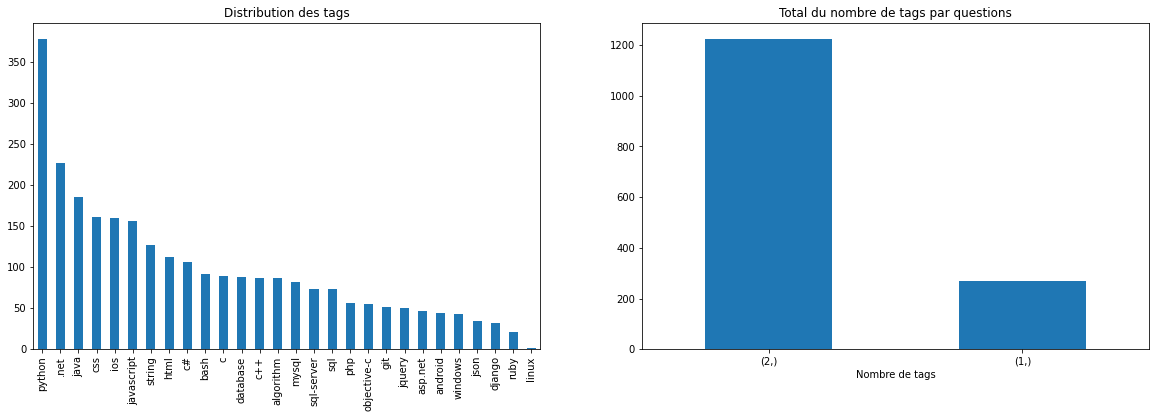

In [ ]:
# Comptage du nombre de tags suggérés dans les prediction LDA
lda_label_count = [len(taggs) for taggs in lda_label_tags]

plot_tag_list_count(lda_label_tags, lda_label_count)

# <font color="red" id=section_4> 4. Suggestion avec modèle Word2Vec </font>

Il existe deux méthodes pour obtenir un embedding en deep learning : soit en apprenant le poids des embeddings pendant l'entraînement soit en chargeant des embeddings pré-entraînés. Dans cette section et la suivante, nous employerons ces deux méthodes. 

En principe, il est possible d'apprendre l'embedding de notre corpus d'entraînement directement grâce à la couche **Embedding** de la bibliothèque `Keras`. Les poids sont initialisés aléatoirement et seront progressivement ajustés par rétropropagation (*on-the-fly*).
Ici, nous allons d'abord générer une matrice d'embedding à l'aide du modèle **Word2Vec** du package `gensim`. Les poids des embeddings ainsi obtenus (pré-entrainés également !) seront ensuite fournit à la couche `Keras` dans le but d'optimiser la performance du modèle. Pour terminer, il y aura une seule couche dense qui sera entraînée pour la classification.

In [29]:
# Chargement des jeux de données train & test
Body = 'Body_lm'

mlb = MultiLabelBinarizer()

train_feats, test_feats, train_label_bin, test_label_bin, mlb = load_train_test_corpus(
    'train_df_tronc.csv',
    'test_df_tronc.csv',
    Body,
    mlb
)

Load train_df_tronc.csv
Load test_df_tronc.csv

Features:
Shape of x train: (36464,)
Shape of x test: (1496,)

Target Binarization:


100%|██████████| 1496/1496 [00:00<00:00, 111621.28it/s]

Shape of y train: (36464, 35)
Shape of y test: (1496, 35)


## Création de l'embedding Word2Vec

In [30]:
# Dimension de l'espace d'embedding
w2v_dim=300 

In [31]:
# Création et entraînement du modèle d'embedding Word2Vec de gensim
print("Build & train gensim Word2Vec embedding model ...")
w2v_model = gensim.models.Word2Vec(
    min_count=2, 
    window=5,
    vector_size=w2v_dim,
    seed=42,
    workers=8
)
w2v_model.build_vocab(train_feats)
w2v_model.train(
    train_feats, 
    total_examples=w2v_model.corpus_count, 
    epochs=10
)
print("Word2Vec trained")

# Vecteurs d'embedding entraîné sur le corpus
model_vectors  = w2v_model.wv
w2v_vocab      = model_vectors.index_to_key
print("gensim Word2Vec vocabulary size: %i" % len(w2v_vocab))

Build & train gensim Word2Vec embedding model ...
Word2Vec trained
gensim Word2Vec vocabulary size: 17201


## Création de la matrice d'embedding

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_feats) 

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Number of unique words: 32763


In [33]:
# # word_index = tokenizer.word_index
# print('Keras Tokenizer() vocabulary size :', len(tokenizer.word_index) + 1)

In [34]:
print("Create Embedding matrix ...")
word_index = tokenizer.word_index
embedding_matrix = np.zeros((num_words, w2v_dim))
    
for word, idx in word_index.items():
    if word in w2v_vocab:
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
print("Embedding matrix shape: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Embedding matrix shape: (32763, 300)


Tokenization des inputs pour l'entraînement et l'inférence.

In [35]:
train_sequences = tokenizer.texts_to_sequences(train_feats) 
train_padded    = pad_sequences(
    train_sequences, 
    maxlen=maxSeq_len, 
#     truncating="post", 
    padding="post"
)

test_sequences = tokenizer.texts_to_sequences(test_feats) 
test_padded    = pad_sequences(
    test_sequences, 
    maxlen=maxSeq_len, 
#     truncating="post", 
    padding="post"
)

## Construction du modèle deep learning

In [36]:
word_input         = keras.layers.Input(shape=(maxSeq_len,), 
                                        dtype='float64', 
                                        name="Input_layer")  
word_embedding     = keras.layers.Embedding(input_dim    = num_words,
                                            output_dim   = w2v_dim,
                                            weights      = [embedding_matrix],
                                            input_length = maxSeq_len,
                                            name         = "Word2Vec_layer")(word_input)

x                  = keras.layers.GlobalAveragePooling1D()(word_embedding)  
word_output        = keras.layers.Dense(nbr_tags, 
                                        activation='sigmoid', 
                                        name="Last_layer")(x)

w2v_embed_model    = keras.models.Model([word_input],word_output)

w2v_embed_model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')])

w2v_embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 128)]             0         
                                                                 
 Word2Vec_layer (Embedding)  (None, 128, 300)          9828900   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 Last_layer (Dense)          (None, 35)                10535     
                                                                 
Total params: 9,839,435
Trainable params: 9,839,435
Non-trainable params: 0
_________________________________________________________________


In [37]:
h = w2v_embed_model.fit(
    train_padded,
    train_label_bin,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/20
228/228 [==============================] - 5s 11ms/step - loss: 0.2518 - accuracy: 0.1407 - val_loss: 0.1446 - val_accuracy: 0.2620
Epoch 2/20
228/228 [==============================] - 2s 9ms/step - loss: 0.1388 - accuracy: 0.2909 - val_loss: 0.1321 - val_accuracy: 0.3359
Epoch 3/20
228/228 [==============================] - 2s 9ms/step - loss: 0.1261 - accuracy: 0.3594 - val_loss: 0.1204 - val_accuracy: 0.3880
Epoch 4/20
228/228 [==============================] - 2s 9ms/step - loss: 0.1147 - accuracy: 0.4174 - val_loss: 0.1104 - val_accuracy: 0.4426
Epoch 5/20
228/228 [==============================] - 2s 9ms/step - loss: 0.1049 - accuracy: 0.4676 - val_loss: 0.1020 - val_accuracy: 0.4802
Epoch 6/20
228/228 [==============================] - 2s 9ms/step - loss: 0.0965 - accuracy: 0.5111 - val_loss: 0.0950 - val_accuracy: 0.5219
Epoch 7/20
228/228 [==============================] - 2s 9ms/step - loss: 0.0893 - accuracy: 0.5467 - val_loss: 0.0892 - val_accuracy: 0.5464
Epoch

## Evaluation du model

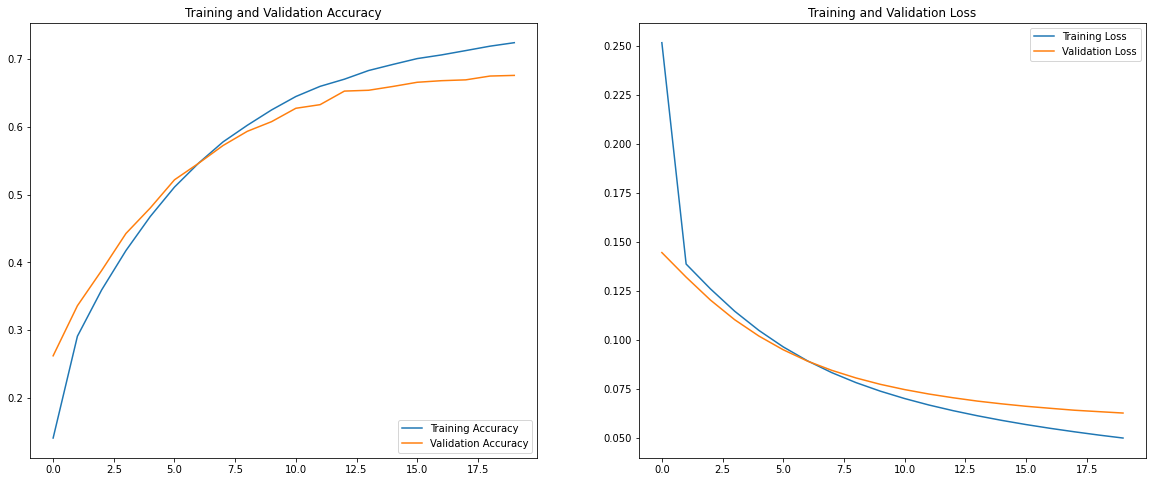

In [38]:
plot_model_history(w2v_embed_model)

In [39]:
w2v_embed_model.evaluate(test_padded, test_label_bin)

47/47 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.6912


[0.0613735131919384, 0.6911764740943909]

## Inférence sur le test set

In [40]:
w2v_label_proba = w2v_embed_model.predict(test_padded)

47/47 [==============================] - 0s 1ms/step


In [58]:
# Binarisation de la matrice des probabilités (Precision vs Recall Trade-off)
tresh = 0.3
w2v_label_proba[w2v_label_proba >= tresh] = 1
w2v_label_proba[w2v_label_proba < tresh] = 0

# Inverse transform
w2v_label_tags  = mlb.inverse_transform(w2v_label_proba)
test_label_tags = mlb.inverse_transform(test_label_bin)

pos = randint(0,test_label_bin.shape[0])
# display(test_df[body].iloc[pos])
# print()
print('predicted label :=', w2v_label_tags[pos])
print('actual label :=',test_label_tags[pos])

predicted label := ()
actual label := ('mysql', 'php')


## Évaluation des suggestions

In [59]:
# Moyennisation des métriques utilisées
avg_index = ['samples avg', 'weighted avg','macro avg', 'micro avg' ]

In [60]:
w2v_report = pd.DataFrame(classification_report(
    test_label_bin,
    w2v_label_proba,
    output_dict=True,
    target_names=mlb.classes_,
    zero_division=0
)).T

w2v_avg_report = w2v_report.loc[avg_index]
w2v_avg_report

,precision,recall,f1-score,support
samples avg,0.651749,0.689951,0.648512,1962.0
weighted avg,0.752607,0.658512,0.700561,1962.0
macro avg,0.693566,0.596975,0.638762,1962.0
micro avg,0.755556,0.658512,0.703704,1962.0


In [61]:
w2v_clf_report = w2v_report[~w2v_report.index.isin(w2v_avg_report.index)]
w2v_clf_report.sort_values(by='f1-score', ascending=False)

,precision,recall,f1-score,support
git,0.981818,1.000000,0.990826,54.0
android,0.941176,0.833333,0.883978,96.0
python,0.925926,0.824176,0.872093,182.0
java,0.911565,0.792899,0.848101,169.0
django,0.913043,0.777778,0.840000,27.0
css,0.875000,0.777778,0.823529,45.0
c++,0.833333,0.765306,0.797872,98.0
php,0.864407,0.708333,0.778626,72.0
sql-server,0.727273,0.800000,0.761905,30.0
ruby-on-rails,0.833333,0.689655,0.754717,29.0


On peut voir qu'avec le modèle Word2Vec tout les tags ont été suggérés. Pour les labels les plus représentés, on a le scénario idéal avec les trois métriques étant supérieure à 0.8. Pour les classes sous-représentées, on trouve également des précisions élevées mais des rappels plutôt moyens: le modèle prédit gloablement peu (certaines suggestions sont vides ! voir ci-dessous) mais bien. 

unique tags :=  35


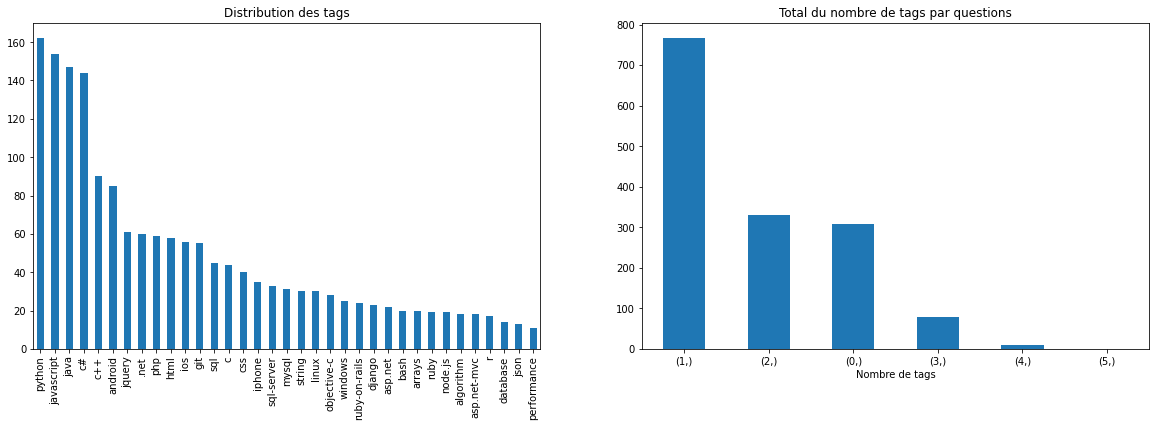

In [62]:
# Comptage du nombre de tags suggérés dans les predictions w2v
w2v_label_count = [len(taggs) for taggs in w2v_label_tags]

plot_tag_list_count(w2v_label_tags, w2v_label_count)

# <font color="red" id=section_5> 5. Modélisation via Transfer Learning. </font>

Enfin, nous allons modéliser le système de suggestions de tags via deux modèles de transfer learning: [BERT](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4) et [USE](https://tfhub.dev/google/universal-sentence-encoder/4). 
Grâce à leur pré-entrainement sur de grands corpus de texte, ces modèles possèdent une "représentation" linguistique du vocabulaire qui leurs sont propres. Il est ensuite possible de les customiser pour une tâche particulière (donc de le ré-entraîner sur un corpus en particulier).

Ici, il n'est pas utile de vectoriser "à-la-main" les documents en amont car ces deux modèles peuvent pratiquement prendre le texte brut en input. Les deux modèles possèdent leurs propres algorithmes d'encodages de séquences. 
Nous allons utiliser le second corpus `Body_pc` qui est l'équivalent contextualisé de `Body_lm`. Comme précédemment, la sortie des modèles sera fournit directement à un classifieur avec une sigmoïde comme activation. qui fournira les probabilités de pertinences pour chaque tags (seuil à 0.3).

In [52]:
import tensorflow_hub as hub
import tensorflow_text as text

In [53]:
# A faire tourner sur Google Colab

# Chargement des jeux de données train & test
Body = 'Body_pc'

mlb = MultiLabelBinarizer()

tl_train_feats, tl_test_feats, train_label_bin, test_label_bin, mlb = load_train_test_corpus(
    'train_df_tronc.csv',
    'test_df_tronc.csv',
    Body, 
    mlb,
    apply=False)

Load train_df_tronc.csv
Load test_df_tronc.csv

Features:
Shape of x train: (36464,)
Shape of x test: (1496,)

Target Binarization:


100%|██████████| 1496/1496 [00:00<00:00, 118151.63it/s]


Shape of y train: (36464, 35)
Shape of y test: (1496, 35)


In [54]:
# Moyennisation des métriques utilisées
avg_index = ['samples avg', 'weighted avg','macro avg', 'micro avg' ]

# <font color="red" id=section_5_1> 5.1 Suggestion avec le modèle BERT. </font>

`BERT` (Bidirectional Encoder Representations from Transformers) est un modèle de Deep Learning développé par Google en [2018](https://fr.wikipedia.org/wiki/BERT_(mod%C3%A8le_de_langage)).
Son architecture *Transformers*, formé de 12 (ou 24) couches d'encodeurs empilés, prend en entrée la séquence entière de mots en une seule fois contrairement au réseaux de neurones récurrents parcourant la séquence d'entrée mots par mots (de manière unidirectionnelle). Chaque encodeur se compose de deux sous-couches : une couche d'auto-attention suivie d'un réseau de neurones complètement connecté. Cette caractéristique permet au modèle d'apprendre le contexte d'un mot à partir de la séquence entière.

<!-- Since BERT’s goal is to generate a language model, only the encoder mechanism is necessary.  -->

À la sortie de la dernière couche d'encodeur, le modèle fournit trois type de sortie pour une séquence:
 1. `pooled_output` : Un embedding pour la sequence entière (de dimension (batch_size, 768)).
 2. `sequence_output` : Un embedding pour chaque token de la sequence (de dimension (batch_size, max_seqlen=128, 768)).
 3. `encoder_output` : Est une liste python qui retourne l'embedding précedent à la sortie de chacunes des couches intermédiaires d'encodeurs.

## Contruction du modèle

In [55]:
# Couche de preprocessing
bert_preprocess = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", 
    name="BERT_preprocessing_layer"
)
# Couche d'encodage
bert_encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", 
    trainable=True, 
    name="BERT_encoding_layer"
)

In [56]:
text_input        = tf.keras.layers.Input(shape=(), 
                                          dtype=tf.string, 
                                          name= "Input_layer")
preprocessed_text = bert_preprocess(text_input)
encoded_text      = bert_encoder(preprocessed_text)

b = encoded_text['pooled_output']
b = tf.keras.layers.Dense(nbr_tags, 
                          activation='sigmoid', 
                          name="Last_layer")(b)

bert_embed_model = tf.keras.Model(inputs=[text_input], outputs = b)

bert_embed_model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-6), 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')]
)

bert_embed_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_layer (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 BERT_preprocessing_layer (Kera  {'input_type_ids':   0          ['Input_layer[0][0]']            
 sLayer)                        (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [57]:
bert_h = bert_embed_model.fit(
    tl_train_feats, 
    train_label_bin,
    validation_split=0.2,
    batch_size=32,
    epochs=15,
)

Epoch 1/15
912/912 [==============================] - 880s 951ms/step - loss: 0.2335 - accuracy: 0.0890 - val_loss: 0.1527 - val_accuracy: 0.1172
Epoch 2/15
912/912 [==============================] - 865s 948ms/step - loss: 0.1422 - accuracy: 0.2637 - val_loss: 0.1207 - val_accuracy: 0.4485
Epoch 3/15
912/912 [==============================] - 867s 951ms/step - loss: 0.1106 - accuracy: 0.4974 - val_loss: 0.0938 - val_accuracy: 0.5596
Epoch 4/15
912/912 [==============================] - 867s 950ms/step - loss: 0.0903 - accuracy: 0.5770 - val_loss: 0.0796 - val_accuracy: 0.6152
Epoch 5/15
912/912 [==============================] - 864s 947ms/step - loss: 0.0779 - accuracy: 0.6219 - val_loss: 0.0717 - val_accuracy: 0.6375
Epoch 6/15
912/912 [==============================] - 863s 946ms/step - loss: 0.0693 - accuracy: 0.6529 - val_loss: 0.0651 - val_accuracy: 0.6635
Epoch 7/15
912/912 [==============================] - 862s 946ms/step - loss: 0.0632 - accuracy: 0.6744 - val_loss: 0.0607 -

## Évaluation du modèle 

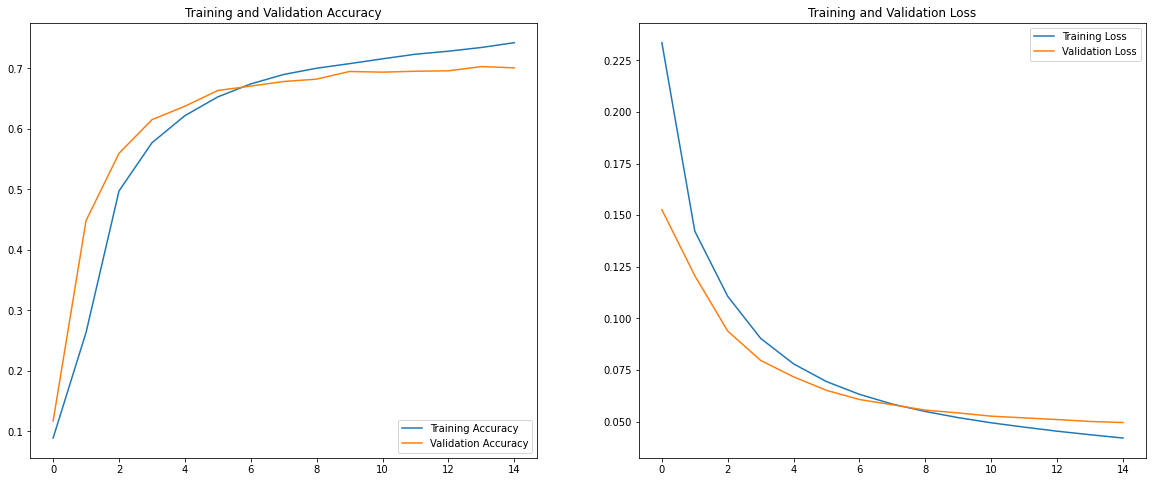

In [63]:
plot_model_history(bert_embed_model)

In [64]:
bert_embed_model.evaluate(tl_test_feats, test_label_bin)

47/47 [==============================] - 15s 322ms/step - loss: 0.0472 - accuracy: 0.7119


[0.047151289880275726, 0.7118983864784241]

## Inférence sur le test set

In [65]:
bert_label_proba = bert_embed_model.predict(tl_test_feats)

47/47 [==============================] - 16s 319ms/step


In [68]:
tresh = 0.3
bert_label_proba[bert_label_proba >= tresh] = 1
bert_label_proba[bert_label_proba < tresh] = 0

# Inverse transform
bert_label_tags = mlb.inverse_transform(bert_label_proba)
test_label_tags = mlb.inverse_transform(test_label_bin)

pos = randint(0,bert_label_proba.shape[0])
print()
print('predicted label :=', bert_label_tags[pos])
print('actual label :=', test_label_tags[pos])


predicted label := ('ios', 'iphone', 'objective-c')
actual label := ('ios',)


## Évaluation des suggestions

In [69]:
bert_report = pd.DataFrame(classification_report(
    test_label_bin,
    bert_label_proba,
    output_dict=True,
    target_names=mlb.classes_,
    zero_division=0
)).T

bert_avg_report = bert_report.loc[avg_index]
bert_avg_report

,precision,recall,f1-score,support
samples avg,0.769608,0.827763,0.774064,1962.0
weighted avg,0.743665,0.796126,0.765311,1962.0
macro avg,0.699265,0.750633,0.718615,1962.0
micro avg,0.737140,0.796126,0.765499,1962.0


In [70]:
bert_clf_report = bert_report[~bert_report.index.isin(bert_avg_report.index)]
bert_clf_report.sort_values(by='f1-score', ascending=False)

,precision,recall,f1-score,support
git,1.000000,0.925926,0.961538,54.0
django,0.960000,0.888889,0.923077,27.0
android,0.906250,0.906250,0.906250,96.0
r,0.851852,0.958333,0.901961,24.0
python,0.862434,0.895604,0.878706,182.0
ruby-on-rails,0.958333,0.793103,0.867925,29.0
css,0.777778,0.933333,0.848485,45.0
java,0.832370,0.852071,0.842105,169.0
c++,0.817308,0.867347,0.841584,98.0
mysql,0.909091,0.769231,0.833333,39.0


Les performances globales avec BERT sont sensiblement meilleures que précédemment. Seul le label `performance` n'a pas été suggéré. Ces deux modèles de Deep Learning montrent un même comportement (en termes de métriques) pour toutes les classes de la variable cible. De plus, on peut voir que le modèle BERT retourne moins de suggestions vides que Word2Vec.

unique tags :=  34


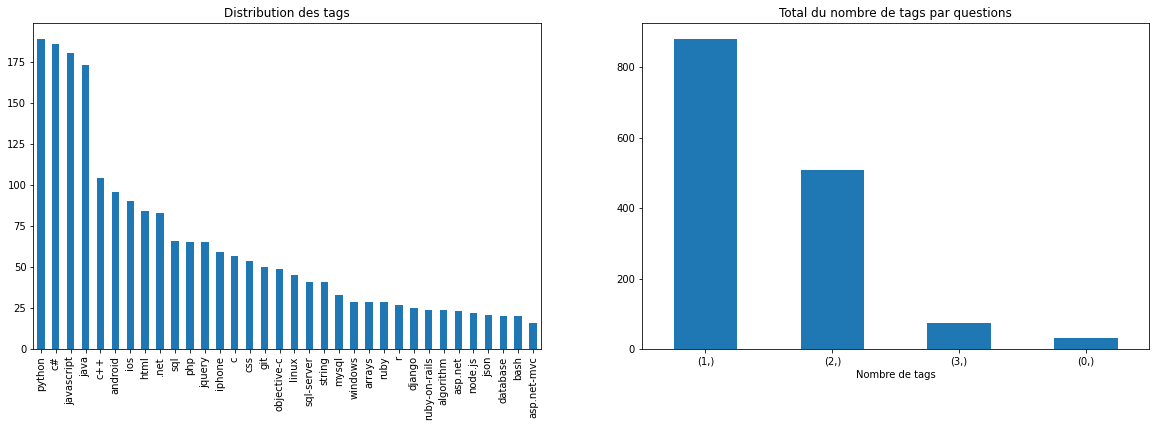

In [71]:
# Comptage du nombre de tags suggérés dans les predictions du modèle BERT
bert_label_count = [len(taggs) for taggs in bert_label_tags]

plot_tag_list_count(bert_label_tags, bert_label_count)

# <font color="red" id=section_5_2> 5.2 Suggestion avec le modèle USE. </font>

`USE` (pour `Universal Sentence Encoder`) est un modèle pré-entraîné de *sentence embeddings* particulièrement adapté pour résoudre des problèmes d'analyse de similarité sémantique de phrases ou de paragraphes, ainsi que pour la classification.

L'architecture du modèle que nous utilisons ici est construite avec un encodeur *Deep Averaging Network*, consistant à calculer un embedding pour la sequence entière en moyennant l'embedding de chacun des tokens de la séquence. Une variante basé sur l'architecture Transformers existe également.

En sortie, le modèle fournit un vecteur d'embedding de dimension 512 par séquences.

## Construction du modèle

In [72]:
use_embed = hub.KerasLayer(
    'https://tfhub.dev/google/universal-sentence-encoder-large/5', 
    trainable=True, 
    name="USE_layer"
)

In [73]:
def build_model():
    
    model = keras.Sequential([
        keras.Input(
            shape=[], 
            dtype=tf.string, 
            name="Input_layer"),
        use_embed,
        # keras.layers.Dropout(0.5),
        keras.layers.Dense(
            nbr_tags, 
            activation='sigmoid', 
            name="Last_layer")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-4),
        loss=tf.keras.losses.BinaryCrossentropy(), 
        metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')]
    )
    return model

use_embed_model = build_model()
use_embed_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_layer (KerasLayer)      (None, 512)               147354880 
                                                                 
 Last_layer (Dense)          (None, 35)                17955     
                                                                 
Total params: 147,372,835
Trainable params: 147,372,835
Non-trainable params: 0
_________________________________________________________________


In [74]:
use_h = use_embed_model.fit(
    np.array(tl_train_feats), 
    train_label_bin,
    validation_split=0.2,
    batch_size=256,
    epochs=15,
)

Epoch 1/15


114/114 [==============================] - 202s 1s/step - loss: 0.4184 - accuracy: 0.0627 - val_loss: 0.2798 - val_accuracy: 0.0643
Epoch 2/15
114/114 [==============================] - 142s 1s/step - loss: 0.2271 - accuracy: 0.1672 - val_loss: 0.1911 - val_accuracy: 0.3776
Epoch 3/15
114/114 [==============================] - 142s 1s/step - loss: 0.1745 - accuracy: 0.4109 - val_loss: 0.1612 - val_accuracy: 0.4540
Epoch 4/15
114/114 [==============================] - 142s 1s/step - loss: 0.1533 - accuracy: 0.4634 - val_loss: 0.1461 - val_accuracy: 0.4951
Epoch 5/15
114/114 [==============================] - 142s 1s/step - loss: 0.1401 - accuracy: 0.5118 - val_loss: 0.1351 - val_accuracy: 0.5254
Epoch 6/15
114/114 [==============================] - 142s 1s/step - loss: 0.1290 - accuracy: 0.5713 - val_loss: 0.1256 - val_accuracy: 0.5759
Epoch 7/15
114/114 [==============================] - 142s 1s/step - loss: 0.1185 - accuracy: 0.6278 - val_loss: 0.1177 - val_accuracy: 0.6135
Epoch 8/15

## Évaluation du modèle 

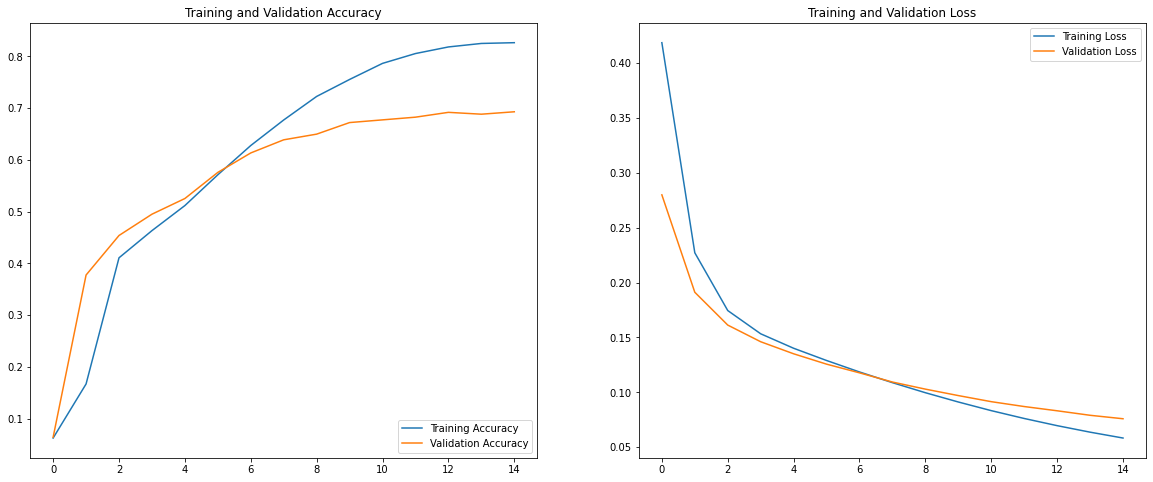

In [75]:
plot_model_history(use_embed_model)

In [76]:
use_embed_model.evaluate(np.array(tl_test_feats), test_label_bin)

47/47 [==============================] - 4s 75ms/step - loss: 0.0742 - accuracy: 0.7005


[0.0741707906126976, 0.7005347609519958]

## Inférence sur le test set

In [77]:
use_label_proba = use_embed_model.predict(np.array(tl_test_feats))

47/47 [==============================] - 9s 74ms/step


In [78]:
tresh = 0.3
use_label_proba[use_label_proba >= tresh] = 1
use_label_proba[use_label_proba < tresh] = 0

# Inverse transform
use_label_tags  = mlb.inverse_transform(use_label_proba)
test_label_tags = mlb.inverse_transform(test_label_bin)

pos = randint(0,use_label_proba.shape[0])
# display(test_df_short.iloc[pos])
print()
print('predicted label :=', use_label_tags[pos])
print('actual label :=',test_label_tags[pos])


predicted label := ('python',)
actual label := ('python',)


## Évaluation des suggestions

In [79]:
use_report = pd.DataFrame(classification_report(
    test_label_bin,
    use_label_proba,
    output_dict=True,
    target_names=mlb.classes_,
    zero_division=0
)).T

use_avg_report = use_report.loc[avg_index]
use_avg_report

,precision,recall,f1-score,support
samples avg,0.753287,0.713012,0.712277,1962.0
weighted avg,0.759977,0.659021,0.683090,1962.0
macro avg,0.685633,0.476565,0.524022,1962.0
micro avg,0.811676,0.659021,0.727426,1962.0


In [80]:
use_clf_report = use_report[~use_report.index.isin(use_avg_report.index)]
use_clf_report.sort_values(by='f1-score', ascending=False)

,precision,recall,f1-score,support
git,1.000000,0.981481,0.990654,54.0
android,0.949495,0.979167,0.964103,96.0
python,0.873684,0.912088,0.892473,182.0
c++,0.905263,0.877551,0.891192,98.0
css,0.886364,0.866667,0.876404,45.0
java,0.840000,0.869822,0.854651,169.0
php,0.842857,0.819444,0.830986,72.0
javascript,0.858065,0.777778,0.815951,171.0
ruby-on-rails,1.000000,0.620690,0.765957,29.0
ios,0.736111,0.791045,0.762590,67.0


Bien que nous avons utilisé un *trade-off* precision/rappel relativement petit (`tresh = 0.3`), on voit que le modèle `USE` est le moins performant des modèles Deep Learning employés (pourtant, celui-ci est moins chronophage que BERT). Le *f1-score* des meilleures suggestions restent cependant du même ordre de grandeur que pour le modèle BERT. De plus, on peut voir que ce modèle retourne plus de suggestions vides que les deux modèles de Deep Learning précédents.

unique tags :=  30


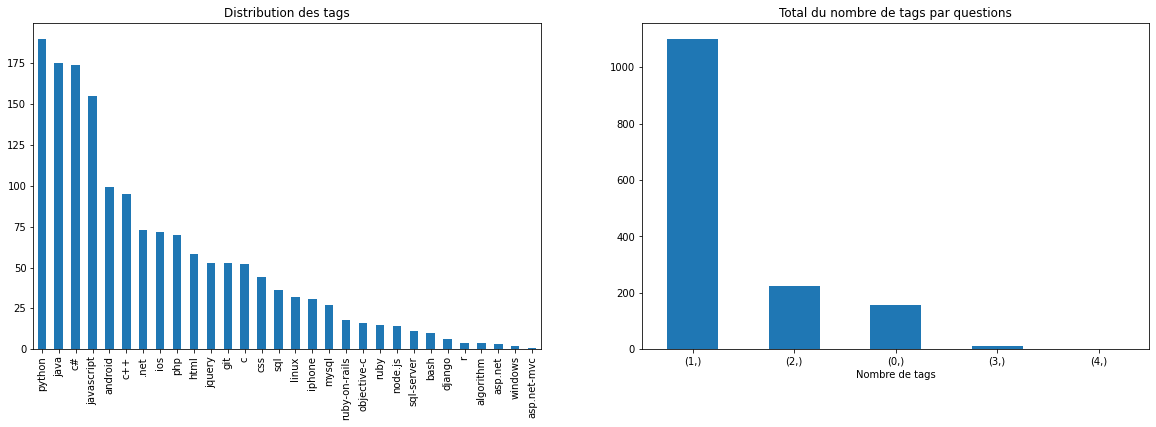

In [81]:
# Comptage du nombre de tags suggérés dans les predictions USE
use_label_count = [len(taggs) for taggs in use_label_tags]

plot_tag_list_count(use_label_tags, use_label_count)

# En conclusion

Pour ce projet de suggestion de tags, nous avons utilisés des modèles de Machine et Deep Learning pour modéliser le système de suggestion. Malgré l'extrême simplicité du système de suggestions customisé basé sur la modélisation LDA, on obtients des prédictions pertinentes lorsque le topic est clairement identifiable. Par exemple, on trouve un f1-score de l'ordre de plus de 0.7 pour `git`, quelque soit le nombre de topic optimal.

En deep learning, nous avons obtenus qu'un simple modèle WordVec peut être aussi performant que les modèles pré-entraînés de l'état de l'art. Le modèle BERT est le plus performant parmi les modèles testés. Pour bien prédire les tags, ces modèles "ne prennent pas de risques" et "préfèrent" retourner des suggestions vides. Pour tout les modèles, il y a très peu de de suggestions avec plus de 3 tags. Le modèle Word2Vec peut-être préféré à tout les modèles employés dans ce notebook en raison du petit temps de calcul (et d'espace mémoire) nécessaire.

Une image docker a été [construite](https://hub.docker.com/r/aliheadou/tagssuggestionwebapp) en utilisant le modèle Word2Vec. 